In [2]:
import numpy as np
import pandas as pd
import os
import sys
import mne
np.random.seed(123456789)
sys.path.append('../../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.maintvbexp import MainTVBSim
from tvbsim.io.patient.subject import Subject
from tvbsim.io.simdata.loadtvbdata import StructuralDataLoader
from tvbsim.io.loadsimdataset import LoadSimDataset
from tvbsim.base.constants.config import Config

from tvbsim.base.preprocess.mne.main import FreqAnalysis

from tvbsim.execute.cluster.hpc_tvbsimmodel import SimVsRealModel
from tvbsim.execute.cluster.hpc_tvbsimmodel import TVBSimModel

from tvbsim.visualize.old import plotts
# sys.path.append('../../../bintng/util/')
# from run_freq import FreqAnalysis

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config() 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

figdir = os.path.join('/Users/adam2392/Documents/figures/raw_freq_analysis/')

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext line_profiler
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

   INFO  log level set to INFO


In [3]:
def load_raw_data(patdatadir, datafile, metadatadir, patient, reference):
    loader = LoadSimDataset(root_dir=patdatadir, 
                                datafile=datafile, 
                                rawdatadir=metadatadir, 
                                patient=patient,
                                reference=reference, 
                                preload=True)
    # get filtered/referenced rawdata
    epits = loader.epits
    rawdata = loader.rawdata 
    metadata = loader.getmetadata()

    return epits, rawdata, metadata

def load_real_data(patient, rawdatadir, idatafile, type_recording='sz', reference='monopolar'):
    # if we are clipping the datasets:
    loader = Subject(name=patient,
                    root_dir=rawdatadir,
                    preload=True,
                    SIM=False)
    seiz_recordings = loader.seizure_recordings
    ii_recordings = loader.interictal_recordings
    print("These are our seizure recordings!: ", loader.seizure_recordings)
    print("These are our interictal recordings!: ", loader.interictal_recordings)
#     if type_recording == 'sz':
#         idatafile = [idx for idx, name in enumerate(loader.seizure_files) if datafile in name]
#     elif type_recording == 'ii':
#         idatafile = [idx for idx, name in enumerate(loader.interictal_files) if datafile in name]
#     assert len(idatafile) == 1
#     idatafile = idatafile[0]

    # extract raw and metadata
    rawdata, metadata = loader.load_dataset(idatafile,  
                                            reference=reference, 
                                            sync=True)
    print(rawdata.shape)
    print(metadata.keys())
    return rawdata, metadata

def compute_timepoints(winsize, stepsize, samplerate, numtimepoints):
    # Creates a [n,2] array that holds the time range of each window
    # in the analysis over sliding windows.

    # trim signal and then convert into milliseconds
    # numtimepoints = numtimepoints - numtimepoints%(self.samplerate/6)
    timepoints_ms = numtimepoints * 1000. / samplerate

    # create array of indices of window start and end times
    timestarts = np.arange(0, timepoints_ms - winsize + 1, stepsize)
    timeends = np.arange(winsize - 1, timepoints_ms, stepsize)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts[:, np.newaxis],
                           timeends[:, np.newaxis], axis=1)
    return timepoints

In [5]:
patient = 'id001_bt'

In [6]:
from tvbsim.exp.master import MasterExp

root_dir = os.path.join('/Users/adam2392/Downloads/tngpipeline/', patient)
loader = StructuralDataLoader(root_dir = root_dir)

## OUTPUTFILE NAME ##
outputdatadir = '~/Downloads/simexp/'
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
    
i = 0
outputfilename = os.path.join(outputdatadir,
            '{}_{}.npz'.format(patient, i))
metafilename = os.path.join(outputdatadir,
            '{}_{}.json'.format(patient, i))


# load in the data to run frequency analysis
reference = 'monopolar'
patdatadir = outputdatadir
metadatadir = root_dir
datafile = outputfilename
epits, seegts, metadata = load_raw_data(patdatadir, datafile, metadatadir, patient, reference)

2018-06-22 15:48:39,070 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-22 15:48:39,072 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-22 15:48:39,074 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-22 15:48:39,095 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
NOT USING SUBCORT
2018-06-22 15:48:52,125 - DEBUG - StructuralDataLoader - 
Loaded in seeg xyz coords!

2018-06-22 15:48:57,626 - DEBUG - StructuralDataLoader - 
Mapped contacts to regions!

2018-06-22 15:48:57,662 - 

In [8]:
idatafile = 0
rawdata, realmetadata = load_real_data(patient, root_dir, idatafile, 
                                   type_recording='sz', reference='monopolar')

2018-06-22 15:49:04,034 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-22 15:49:04,036 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-22 15:49:04,055 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-22 15:49:04,075 - INFO - Subject - 
Loaded in ez hypothesis!

   INFO  
Loaded in ez hypothesis!

2018-06-22 15:49:21,396 - DEBUG - Subject - 
Loaded in seeg xyz coords!

2018-06-22 15:49:25,577 - DEBUG - Subject - 
Mapped contacts to regions!

reading fif
reading fif
reading fif
reading fif
reading fif
('These are ou

In [12]:
print("Datafile we loaded was: ", datafile)
print(rawdata.shape)
print(realmetadata.keys())

('Datafile we loaded was: ', '~/Downloads/simexp/id001_bt_0.npz')
(97, 766976)
['ez_region', 'offsetsec', 'reference', 'onsetsec', 'type', 'offsetind', 'contact_regs', 'rawfilename', 'onsetind', 'bad_channels', 'record_date', 'lowpass_freq', 'region_labels', 'non_eeg_channels', 'samplerate', 'chanxyz', 'linefreq', 'highpass_freq', 'chanlabels']


In [13]:
print(metadata['rawfilename'])
print(realmetadata['rawfilename'])

~/Downloads/simexp/id001_bt_0.npz
/Users/adam2392/Downloads/tngpipeline/id001_bt/seeg/fif/BTcrisepartielle+preictalspiking_0009.raw.fif


# Compute PSD And Bin Them

Effective window size : 0.250 (s)
Effective window size : 0.512 (s)
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512.0])
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 250])
alpha
beta
gamma
high
('real psd: ', 3.9474067165640507, -2.706156882033303)
('sim psd: ', 1.4416044037995177, -5.032346743374993)
('winsize: ', 5000)
('stepsize: ', 2500)
(97, 128)
(50,)
(97, 4, 1)
(137, 4, 1)
(305, 2)
(305, 2)
CPU times: user 4.41 s, sys: 1.96 s, total: 6.37 s
Wall time: 6.42 s


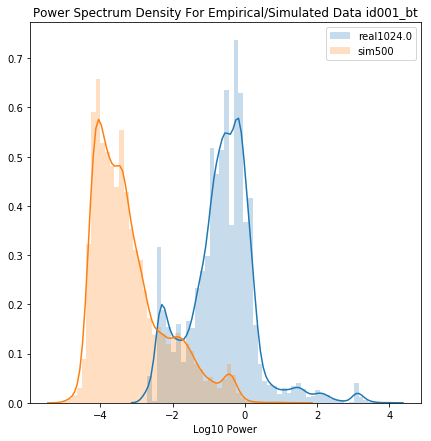

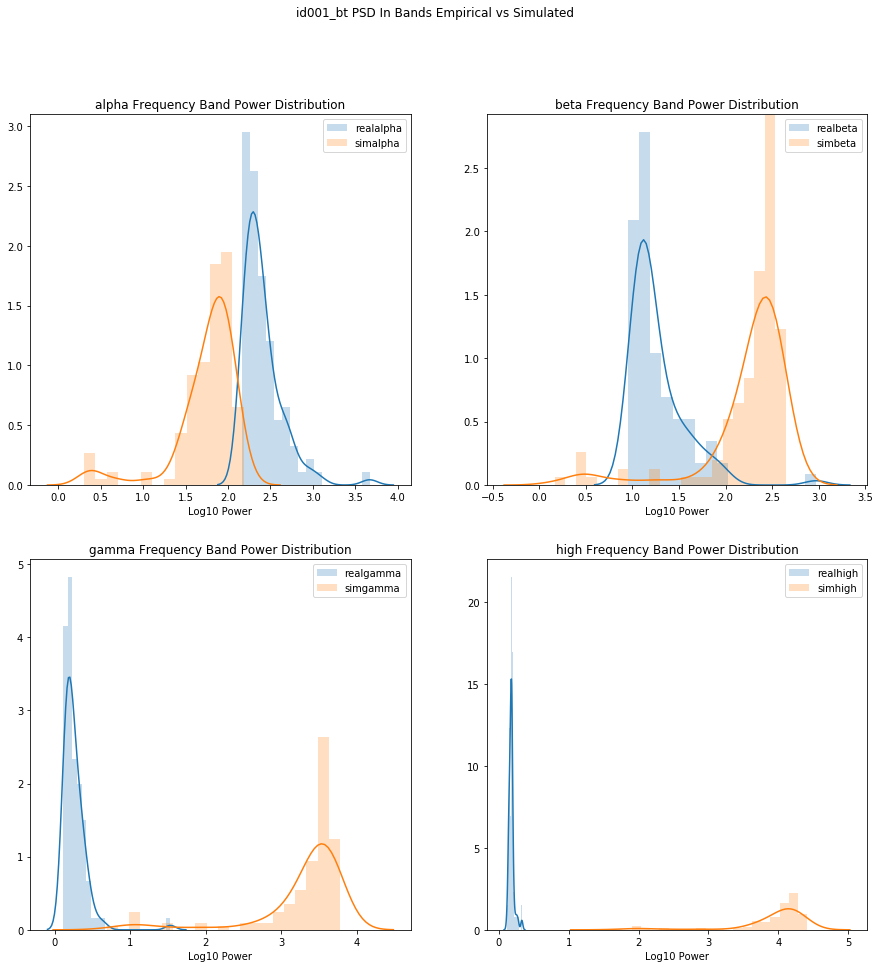

In [88]:
%%time
###############################################################
# Run Real freq analysis
winsize = 5000
stepsize = 2500
samplerate = realmetadata['samplerate']
fmin = 0.5
fmax = samplerate // 2

freqs = np.arange(1., samplerate//2, 5.)
waveletfreqs = 2**(np.arange(1.,9.,1./5))

# for binning frequencies
freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}

# run psd analysis
real_freqanalysis = FreqAnalysis(winsize, stepsize, samplerate, freqs)
psd, freqs = real_freqanalysis.psd(rawdata, fmin, fmax, psdtype='welch')
real_freqanalysis.compute_samplepoints(rawdata.shape[1])

###############################################################
# Run Sim freq analysis
simsamplerate = 500
freqs = np.arange(1., simsamplerate//2, 5.)
fmax = simsamplerate // 2
waveletfreqs = 2**(np.arange(1.,9.,1./5))
# for binning frequencies
simfreqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, simsamplerate//2],
}

sim_freqanalysis = FreqAnalysis(winsize, stepsize, simsamplerate, freqs)
simpsd, simfreqs = sim_freqanalysis.psd(seegts, fmin, fmax, psdtype='welch')
sim_freqanalysis.compute_samplepoints(epits.shape[1])

###############################################################
# PLOTTING
###############################################################

plt.figure(figsize=(7,7))
ax = sns.distplot(psd.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax = sns.distplot(simpsd.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(simsamplerate))
ax.set_title('Power Spectrum Density For Empirical/Simulated Data {}'.format(patient))
ax.legend()
plt.xlabel('Log10 Power')
figfilename = os.path.join(figdir, '{}_psd_comparison_srate{}.pdf'.format(patient, simsamplerate))
plt.savefig(figfilename)

realpower_binned = real_freqanalysis.binfreqvalues(psd, freqs, freqbands)
simpower_binned = sim_freqanalysis.binfreqvalues(simpsd, simfreqs, simfreqbands)

# Plot After binning into frequency bands!
plt.figure(figsize=(15,15))
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    plt.subplot(2,2,i+1)
    sns.distplot(realpower_binned[:,i,:].ravel(), kde=True,
                     hist_kws={'alpha': 0.25}, label='real'+label)
    sns.distplot(simpower_binned[:,i,:].ravel(), 
                hist_kws={'alpha': 0.25}, 
                 kde=True, label='sim'+label)
    plt.legend()
    plt.title('{} Frequency Band Power Distribution'.format(label))
    plt.xlabel('Log10 Power')
    plt.suptitle('{} PSD In Bands Empirical vs Simulated'.format(patient))
    figfilename = os.path.join(figdir, '{}_psd_bands_comparison_srate{}.pdf'.format(patient, simsamplerate))
    plt.savefig(figfilename)

# print some output to debug
print("real psd: ", max(psd.ravel()), min(psd.ravel()))
print("sim psd: ", max(simpsd.ravel()), min(simpsd.ravel()))
print("winsize: ", winsize)
print("stepsize: ", stepsize)
print(psd.shape)
print(freqs.shape)
print(realpower_binned.shape)
print(simpower_binned.shape)
print(real_freqanalysis.samplepoints.shape)
print(real_freqanalysis.timepoints.shape)

# Compute TFR and Plot them And Bin Them Together

In [14]:
%%time
###############################################################
# Run Real freq analysis
winsize = 5000
stepsize = 2500
samplerate = realmetadata['samplerate']
fmin = 0.5
fmax = samplerate // 2

freqs = np.arange(1., samplerate//2, 5.)
freqs = 2**(np.arange(1.,9.,1./5))

# for binning frequencies
freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}

# run psd analysis
real_freqanalysis = FreqAnalysis(winsize, stepsize, samplerate, freqs)
power, freqs = real_freqanalysis.tfr(rawdata, psdtype='stft')
real_freqanalysis.compute_samplepoints(rawdata.shape[1])

Number of frequencies: 2501
Number of time steps: 307
CPU times: user 5.34 s, sys: 1.79 s, total: 7.13 s
Wall time: 7.3 s


In [26]:
%%time
###############################################################
# Run Sim freq analysis
simsamplerate = 2048
freqs = np.arange(1., simsamplerate//2, 5.)
fmax = simsamplerate // 2
waveletfreqs = 2**(np.arange(1.,9.,1./5))
# for binning frequencies
simfreqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, simsamplerate//2],
}

sim_freqanalysis = FreqAnalysis(winsize, stepsize, simsamplerate, freqs)
simpower, simfreqs = sim_freqanalysis.tfr(seegts, psdtype='stft')
sim_freqanalysis.compute_samplepoints(epits.shape[1])

Number of frequencies: 2501
Number of time steps: 6
CPU times: user 147 ms, sys: 55.2 ms, total: 202 ms
Wall time: 209 ms


In [22]:
decimation_factor = 100
s = np.random.choice(power.ravel(), len(power.ravel()) // decimation_factor)
# To check the final size
s.shape

(744772,)

('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512.0])
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1024])
alpha
beta
gamma
high
('winsize: ', 5000)
('stepsize: ', 2500)
('Real TFR Binned shape: ', (97, 4, 307))
('Sim TFR Binned shape: ', (137, 4, 6))
(307, 2)
(307, 2)


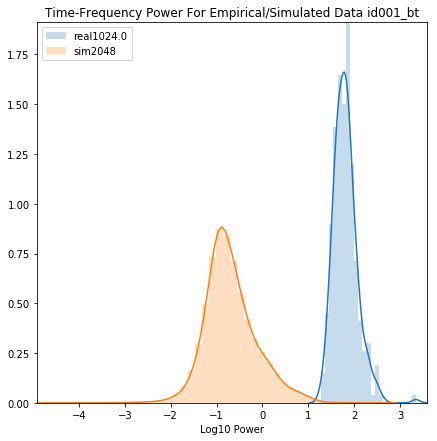

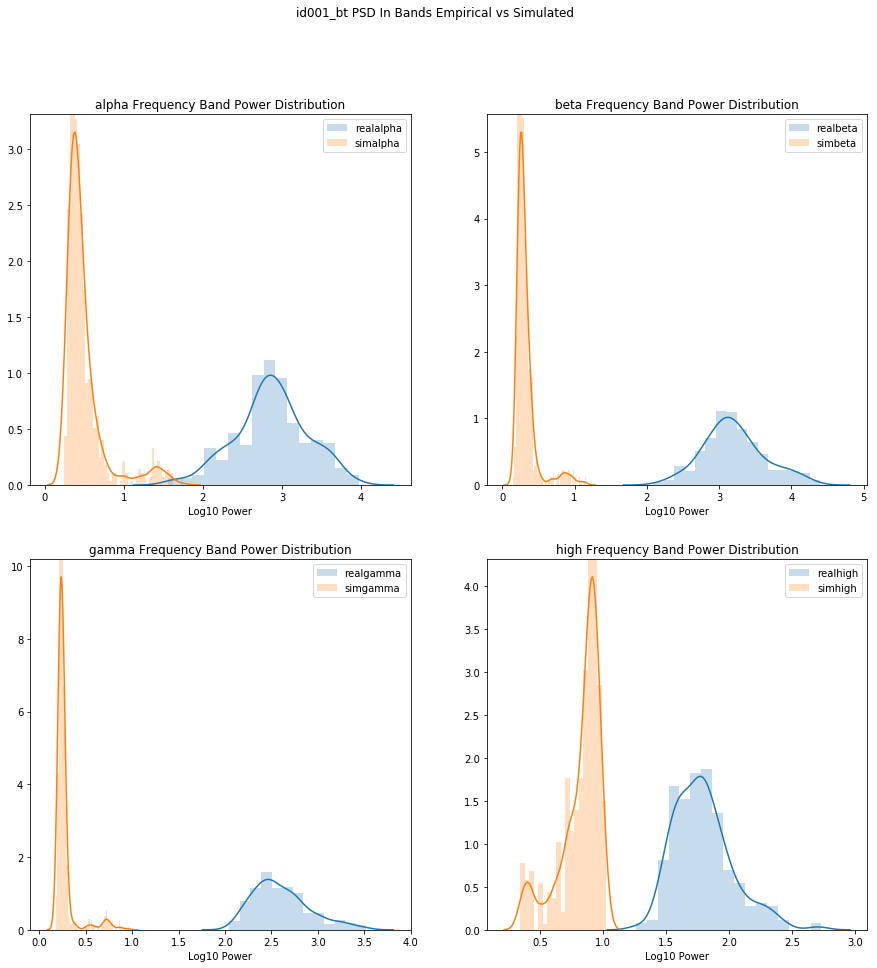

In [27]:
##############################################################
# PLOTTING
###############################################################
plt.figure(figsize=(7,7))
ax = sns.distplot(s.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax = sns.distplot(simpower.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(simsamplerate))
ax.set_title('Time-Frequency Power For Empirical/Simulated Data {}'.format(patient))
ax.legend()
plt.xlabel('Log10 Power')
figfilename = os.path.join(figdir, '{}_tfr_psd_comparison_srate{}.pdf'.format(patient, simsamplerate))
plt.savefig(figfilename)

realpower_binned = real_freqanalysis.binfreqvalues(power, freqs, freqbands)
simpower_binned = sim_freqanalysis.binfreqvalues(simpower, simfreqs, simfreqbands)

# Plot After binning into frequency bands!
plt.figure(figsize=(15,15))
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    plt.subplot(2,2,i+1)
    decimation_factor = 100
    s = np.random.choice(realpower_binned[:,i,:].ravel(), len(realpower_binned[:,i,:].ravel()) // decimation_factor)
    # To check the final size
    s.shape
    sns.distplot(s, kde=True,
                     hist_kws={'alpha': 0.25}, label='real'+label)
    sns.distplot(simpower_binned[:,i,:].ravel(), 
                hist_kws={'alpha': 0.25}, 
                 kde=True, label='sim'+label)
    plt.legend()
    plt.title('{} Frequency Band Power Distribution'.format(label))
    plt.xlabel('Log10 Power')
    plt.suptitle('{} PSD In Bands Empirical vs Simulated'.format(patient))
    figfilename = os.path.join(figdir, '{}_tfr_psd_bands_comparison_srate{}.pdf'.format(patient, simsamplerate))
    ax.autoscale(tight=True)
    plt.savefig(figfilename)

# print some output to debug
print("winsize: ", winsize)
print("stepsize: ", stepsize)
print("Real TFR Binned shape: ", realpower_binned.shape)
print("Sim TFR Binned shape: ", simpower_binned.shape)
print(real_freqanalysis.samplepoints.shape)
print(real_freqanalysis.timepoints.shape)

# Plot Them Together Example

This is an example of a plot of STFT decomposition results for empirical and simulated data.

Number of frequencies: 2501
Number of time steps: 307
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512.0])
Number of frequencies: 2501
Number of time steps: 6
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512])
alpha
beta
gamma
high
CPU times: user 6.29 s, sys: 1.78 s, total: 8.08 s
Wall time: 8.09 s


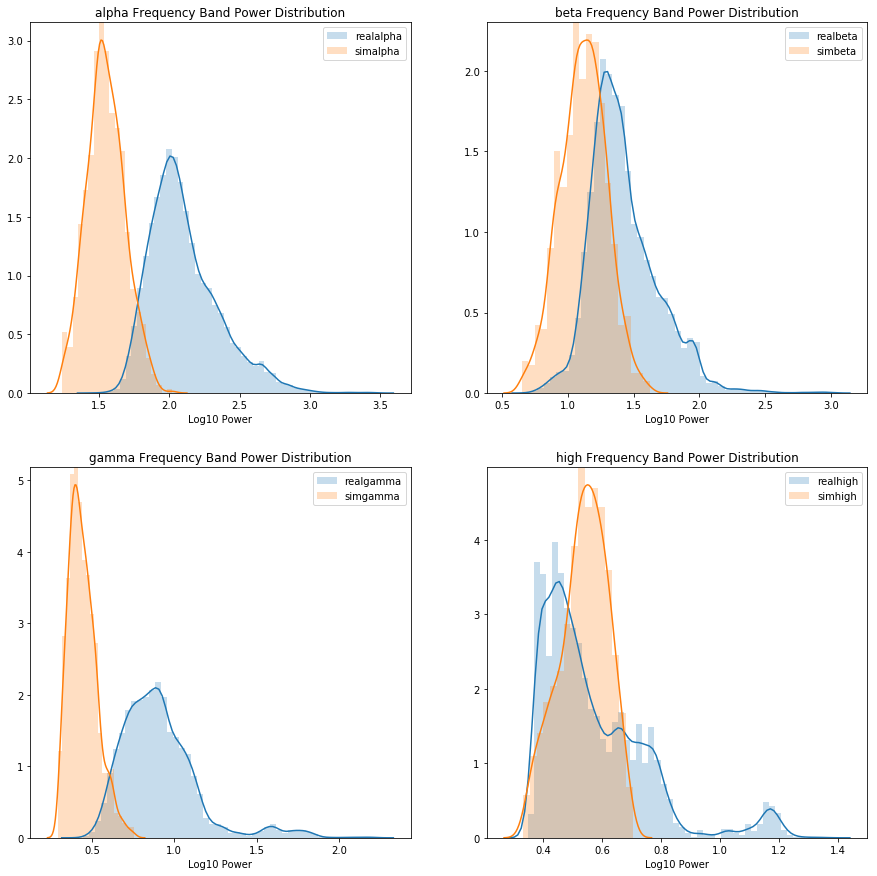

In [42]:
%%time
winsize = 5000
stepsize = 2500
samplerate = metadata['samplerate']
power = mne.time_frequency.stft(rawdata, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
realpower = np.log10(np.abs(power))

freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
realpower_binned = binfreqvalues(realpower, freqs, freqbands)

winsize = 5000
stepsize = 2500
samplerate = 2024
power = mne.time_frequency.stft(seegts, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
simpower = np.log10(np.abs(power))

freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
simpower_binned = binfreqvalues(simpower, freqs, freqbands)

plt.figure(figsize=(15,15))
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    plt.subplot(2,2,i+1)
    sns.distplot(realpower_binned[:,i,:].ravel(), kde=True,
                     hist_kws={'alpha': 0.25}, label='real'+label)
    sns.distplot(simpower_binned[:,i,:].ravel(), 
                hist_kws={'alpha': 0.25}, 
                 kde=True, label='sim'+label)
    plt.legend()
    plt.title('{} Frequency Band Power Distribution'.format(label))
    plt.xlabel('Log10 Power')
    figfilename = os.path.join(figdir, '{}_psd_bands_comparison_srate{}.pdf'.format(patient, samplerate))
    plt.savefig(figfilename)

# Split Into Interictal and Ictal Regions

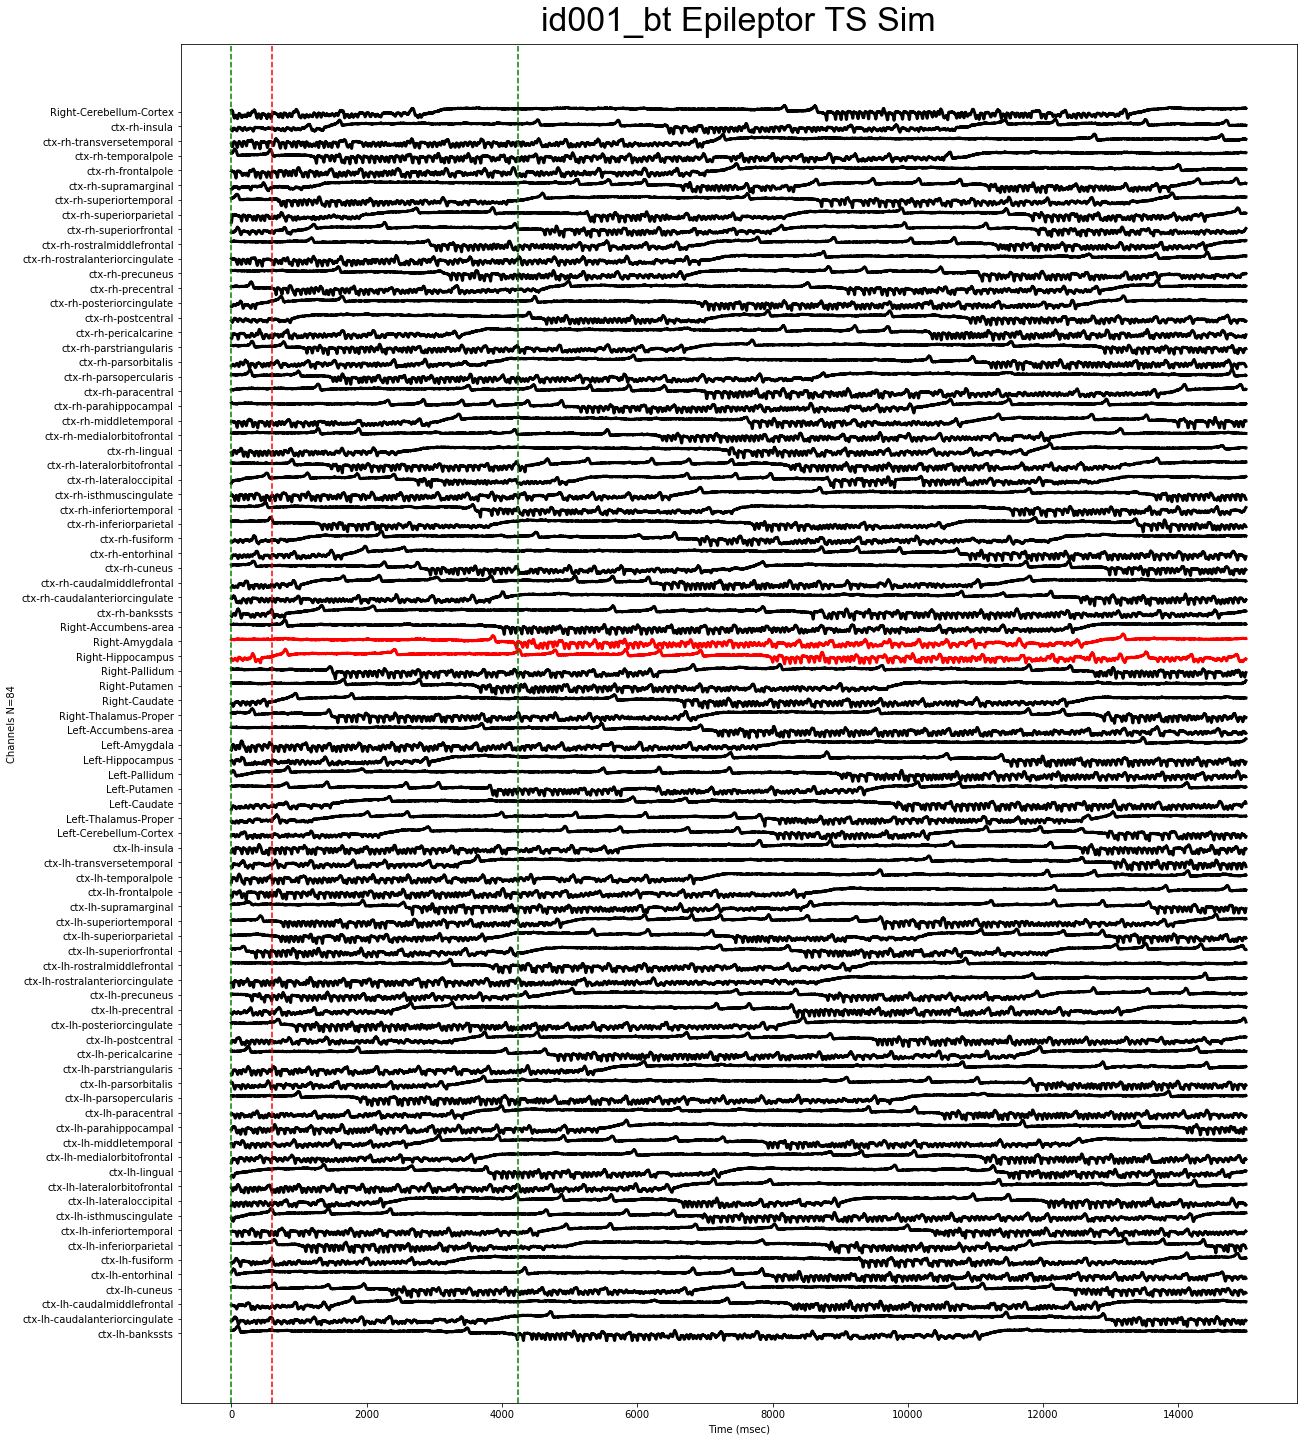

In [51]:
tsviz = tvbsim.visualize.old.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=metadata['region_labels'])
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True, titlestr='{} Epileptor TS Sim'.format(patient))
tsviz.plotvertlines(onsettimes=onsetind, offsettimes=offsetind)
tsviz.colorts(modelezinds, color='red')
tsviz.colorts([], color='blue')

# Notes On Interictal/Ictal Splitting

6/22/18: Data from real portions can be split because interictal/ictal bifurcations happen at timescales greater then our "5000/2500" win/step sizes in terms of "milliseconds". However, the TVB models are not "reflective" of real time scales, but merely phenomological.

So this can probably only begin to be compared once we modify tt parameter within TVB to reflect our realistic time scaling. This way, we can use a 5000/2500 sample win/step size and still be able to split the data's TFR accordingly into interictal and ictal.

In [30]:
modelezregs = metadata['sim_ez_reg']
modelpzregs = metadata['sim_pz_reg']
modelezinds = [ind for ind, reg in enumerate(metadata['region_labels']) if reg in modelezregs]

realonsetind = realmetadata['onsetind']
realoffsetind = realmetadata['offsetind']

onsetind = metadata['onsetind']
offsetind = metadata['offsetind']

print(realonsetind, realoffsetind)
print(onsetind, offsetind)

(90846.208, 215673.856)
([0.0, 1149.0, 2450.0, 3135.0, 4696.0, 6178.0, 7822.0, 9244.0, 10588.0, 11891.0, 12618.0, 14253.0], [630.0, 2227.0, 2900.0, 4200.0, 5543.0, 6931.0, 8511.0, 10137.0, 11699.0, 12330.0, 13633.0])


In [32]:
realtimepoints = real_freqanalysis.timepoints
print(realtimepoints.shape)

simtimepoints = sim_freqanalysis.timepoints
print(simtimepoints.shape)

(307, 2)
(6, 2)


In [ ]:
%%time
###############################################################
# Run Real freq analysis
winsize = 5000
stepsize = 2500
samplerate = realmetadata['samplerate']
fmin = 0.5
fmax = samplerate // 2

freqs = np.arange(1., samplerate//2, 5.)
freqs = 2**(np.arange(1.,9.,1./5))

# for binning frequencies
freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}

# run psd analysis
real_freqanalysis = FreqAnalysis(winsize, stepsize, samplerate, freqs)
power, freqs = real_freqanalysis.tfr(rawdata, psdtype='stft')
real_freqanalysis.compute_samplepoints(rawdata.shape[1])

###############################################################
# Run Sim freq analysis
simsamplerate = 2048
freqs = np.arange(1., simsamplerate//2, 5.)
fmax = simsamplerate // 2
waveletfreqs = 2**(np.arange(1.,9.,1./5))
# for binning frequencies
simfreqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, simsamplerate//2],
}

sim_freqanalysis = FreqAnalysis(winsize, stepsize, simsamplerate, freqs)
simpower, simfreqs = sim_freqanalysis.tfr(seegts, psdtype='stft')
sim_freqanalysis.compute_samplepoints(epits.shape[1])

In [ ]:
realonsetwin = real_freqanalysis.mapinds_towins(realonsetind)
realoffsetwin = real_freqanalysis.mapinds_towins(realoffsetind)

simonsetwin = sim_freqanalysis.mapinds_towins(simonsetind)
simoffsetwin = sim_freqanalysis.mapinds_towins(simoffsetind)

In [ ]:
##############################################################
# PLOTTING
###############################################################
plt.figure(figsize=(7,7))
ax = sns.distplot(s.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax = sns.distplot(simpower.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(simsamplerate))
ax.set_title('Time-Frequency Power For Empirical/Simulated Data {}'.format(patient))
ax.legend()
plt.xlabel('Log10 Power')
figfilename = os.path.join(figdir, '{}_tfr_psd_comparison_srate{}.pdf'.format(patient, simsamplerate))
plt.savefig(figfilename)

realpower_binned = real_freqanalysis.binfreqvalues(power, freqs, freqbands)
simpower_binned = sim_freqanalysis.binfreqvalues(simpower, simfreqs, simfreqbands)

# Plot After binning into frequency bands!
plt.figure(figsize=(15,15))
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    plt.subplot(2,2,i+1)
    decimation_factor = 100
    s = np.random.choice(realpower_binned[:,i,:].ravel(), len(realpower_binned[:,i,:].ravel()) // decimation_factor)
    # To check the final size
    s.shape
    sns.distplot(s, kde=True,
                     hist_kws={'alpha': 0.25}, label='real'+label)
    sns.distplot(simpower_binned[:,i,:].ravel(), 
                hist_kws={'alpha': 0.25}, 
                 kde=True, label='sim'+label)
    plt.legend()
    plt.title('{} Frequency Band Power Distribution'.format(label))
    plt.xlabel('Log10 Power')
    plt.suptitle('{} PSD In Bands Empirical vs Simulated'.format(patient))
    figfilename = os.path.join(figdir, '{}_tfr_psd_bands_comparison_srate{}.pdf'.format(patient, simsamplerate))
    ax.autoscale(tight=True)
    plt.savefig(figfilename)

# print some output to debug
print("winsize: ", winsize)
print("stepsize: ", stepsize)
print("Real TFR Binned shape: ", realpower_binned.shape)
print("Sim TFR Binned shape: ", simpower_binned.shape)
print(real_freqanalysis.samplepoints.shape)
print(real_freqanalysis.timepoints.shape)